In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from horama import maco, plot_maco
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset

In [3]:
from neural_regress.regress_lib import sweep_regressors, perform_regression_sweeplayer_RidgeCV, perform_regression_sweeplayer, record_features
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch, LinearLayer_from_sklearn
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths
from core.model_load_utils import load_model_transform

### Set up paths for data loading

In [4]:
import yaml
import glob

In [5]:
config_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs"
subject_id = "red_20250428-20250430"
config_dir = join(config_root, subject_id)
config_files = sorted(glob.glob(join(config_dir, "*.yaml")))

config_files

['/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch0_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch15_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch2_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch9_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-2025043

In [7]:
chan_pattern = "_Ch19_"
config_pre_chan = [f for f in config_files if chan_pattern in f]
config_pre_chan;

['/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_dinov2_vitb14_reg_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_radio_v2.5-b_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_regnety_640_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_resnet50_Ch19_accentuation_config.yaml

### Demo loading

In [8]:
acc_config = yaml.safe_load(open(config_pre_chan[0]))
xtransform_path = acc_config['xtransform_path']
meta_path = acc_config['meta_path']
readout_path = acc_config['readout_path']
model_name = acc_config['model_name']
unit_ids = acc_config['unit_ids']
layer_name = acc_config['layer_name']
regressor = acc_config['fit_method_name']

In [9]:
def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None


device = "cuda"
model, transforms_pipeline = load_model_transform(model_name, device=device)
model = model.eval().to(device)
model.requires_grad_(False)
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name, ingraph=True, store_device=device)
# Load readout layer
readout = th.load(readout_path).to(device)
Xtransform = th.load(xtransform_path).to(device)
# Load PCA transform

def predict_population_response(images):
    """Predict neural population responses for input images.
    
    Args:
        images (torch.Tensor): Input images of shape (batch_size, 3, 224, 224)
        
    Returns:
        torch.Tensor: Predicted neural responses
    """
    model(images)
    feat_tsr = fetcher[layer_name]
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)

check_gradient(predict_population_response)

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/serialization.py:1006: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


torch.Size([1, 64])


In [ ]:
acc_config

{'model_name': 'AlexNet_training_seed_01',
 'fit_method_name': 'RidgeCV',
 'unit_ids': [19],
 'subject_id': 'red_20250428-20250430',
 'layer_name': '.features.MaxPool2d12',
 'outputdir': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430',
 'readout_path': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_readout_.features.MaxPool2d12_pca750_RidgeCV.pth',
 'xtransform_path': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_Xtfmer_.features.MaxPool2d12_pca750_RidgeCV_JITscript.pt',
 'meta_path': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_meta_.features.MaxPool2d12_pca750_RidgeCV.pkl',
 'result_folder': '/n/holylabs/LABS/alvarez_lab/Ev

### Loading at scale

In [10]:
def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None


def get_predictor_from_config(acc_config, device="cuda"):
    """Create a function that predicts neural population responses for images.
    
    Args:
        subject_id (str): ID of the subject
        modelname (str): Name of the model to use (e.g. "resnet50_robust") 
        layer_name (str): Name of layer to extract features from
        device (str): Device to run model on ("cuda" or "cpu")
        
    Returns:
        function: A function that takes images as input and returns predicted population responses
    """
    if isinstance(acc_config, str):
        acc_config = yaml.safe_load(open(acc_config))
        
    # Construct paths
    xtransform_path = acc_config['xtransform_path']
    meta_path = acc_config['meta_path']
    readout_path = acc_config['readout_path']
    model_name = acc_config['model_name']
    unit_ids = acc_config['unit_ids']
    layer_name = acc_config['layer_name']
    regressor = acc_config['fit_method_name']
    print(f"Loading model and set up feature extraction: model {model_name}, layer {layer_name}")
    print(f"Target unit ids: {unit_ids}")
    print(f"Loading readout layer and PCA transform: readout {readout_path}, xtransform             {xtransform_path}")
    # Load model and set up feature extraction
    model, transforms_pipeline = load_model_transform(model_name, device=device)
    model = model.eval().to(device)
    model.requires_grad_(False)
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    fetcher.record(layer_name, ingraph=True, store_device=device)
    # Load readout layer and PCA transform
    readout = th.load(readout_path).to(device)
    Xtransform = th.load(xtransform_path).to(device)
    def predict_population_response(images):
        """Predict neural population responses for input images.
        
        Args:
            images (torch.Tensor): Input images of shape (batch_size, 3, 224, 224)
            
        Returns:
            torch.Tensor: Predicted neural responses
        """
        model(images)
        feat_tsr = fetcher[layer_name]
        feat_vec = Xtransform(feat_tsr)
        return readout(feat_vec)
    
    
    def predict_target_unit_response(images):
        """Predict neural population responses for input images.
        
        Args:
            images (torch.Tensor): Input images of shape (batch_size, 3, 224, 224)
            
        Returns:
            torch.Tensor: Predicted neural responses
        """
        model(images)
        feat_tsr = fetcher[layer_name]
        feat_vec = Xtransform(feat_tsr)
        return readout(feat_vec)[:, unit_ids]

    check_gradient(predict_population_response)
    print("Gradient check passed!")
    return predict_population_response, predict_target_unit_response, \
           model, transforms_pipeline, fetcher, Xtransform, readout
           

def get_PCA_basis_predictor_from_config(acc_config, device="cuda"):
    """Create a function that predicts neural population responses for images.
    
    Args:
        subject_id (str): ID of the subject
        modelname (str): Name of the model to use (e.g. "resnet50_robust") 
        layer_name (str): Name of layer to extract features from
        device (str): Device to run model on ("cuda" or "cpu")
        
    Returns:
        function: A function that takes images as input and returns predicted population responses
    """
    if isinstance(acc_config, str):
        acc_config = yaml.safe_load(open(acc_config))
        
    # Construct paths
    xtransform_path = acc_config['xtransform_path']
    meta_path = acc_config['meta_path']
    readout_path = acc_config['readout_path']
    model_name = acc_config['model_name']
    unit_ids = acc_config['unit_ids']
    layer_name = acc_config['layer_name']
    regressor = acc_config['fit_method_name']
    print(f"Loading model and set up feature extraction: model {model_name}, layer {layer_name}")
    print(f"Target unit ids: {unit_ids}")
    print(f"Loading readout layer and PCA transform: readout {readout_path}, xtransform             {xtransform_path}")
    # Load model and set up feature extraction
    model, transforms_pipeline = load_model_transform(model_name, device=device)
    model = model.eval().to(device)
    model.requires_grad_(False)
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    fetcher.record(layer_name, ingraph=True, store_device=device)
    # Load readout layer and PCA transform
    readout = th.load(readout_path).to(device)
    Xtransform = th.load(xtransform_path).to(device)
    def predict_reduced_feature(images):
        """Predict neural population responses for input images.
        
        Args:
            images (torch.Tensor): Input images of shape (batch_size, 3, 224, 224)
            
        Returns:
            torch.Tensor: Predicted neural responses
        """
        model(images)
        feat_tsr = fetcher[layer_name]
        feat_vec = Xtransform(feat_tsr)
        return feat_vec
    
    check_gradient(predict_reduced_feature)
    print("Gradient check passed!")
    return predict_reduced_feature, \
           model, transforms_pipeline, fetcher, Xtransform, readout

In [ ]:
config_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs"
subject_id = "red_20250428-20250430"
config_dir = join(config_root, subject_id)
config_files = sorted(glob.glob(join(config_dir, "*.yaml")))
chan_pattern = "_Ch19_"
config_pre_chan = [f for f in config_files if chan_pattern in f]

Check that all predictors can be loaded! 

In [11]:
config_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs"
subject_id = "red_20250428-20250430"
config_dir = join(config_root, subject_id)
config_files = sorted(glob.glob(join(config_dir, "*.yaml")))
chan_pattern = "_Ch19_"
config_pre_chan = [f for f in config_files if chan_pattern in f]
for config_file in config_pre_chan:
    predict_reduced_feature, \
        model, transforms_pipeline, fetcher, Xtransform, readout \
            = get_PCA_basis_predictor_from_config(config_file, device="cuda")
    # print(population_predictor)
    # print(target_unit_predictor)

Loading model and set up feature extraction: model AlexNet_training_seed_01, layer .features.MaxPool2d12
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_readout_.features.MaxPool2d12_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_Xtfmer_.features.MaxPool2d12_pca750_RidgeCV_JITscript.pt


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/serialization.py:1006: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model clipag_vitb32, layer .transformer.resblocks.ResidualAttentionBlock9
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_readout_.transformer.resblocks.ResidualAttentionBlock9_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_Xtfmer_.transformer.resblocks.ResidualAttentionBlock9_pca750_RidgeCV_JITscript.pt


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model dinov2_vitb14_reg, layer .blocks.NestedTensorBlock11
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_dinov2_vitb14_reg_Ch19_readout_.blocks.NestedTensorBlock11_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_dinov2_vitb14_reg_Ch19_Xtfmer_.blocks.NestedTensorBlock11_pca750_RidgeCV_JITscript.pt


Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model radio_v2.5-b, layer .model.blocks.Block10
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_radio_v2.5-b_Ch19_readout_.model.blocks.Block10_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_radio_v2.5-b_Ch19_Xtfmer_.model.blocks.Block10_pca750_RidgeCV_JITscript.pt


Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/NVlabs_RADIO_main


torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model regnety_640, layer .s4.Bottleneckb1
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_regnety_640_Ch19_readout_.s4.Bottleneckb1_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_regnety_640_Ch19_Xtfmer_.s4.Bottleneckb1_pca750_RidgeCV_JITscript.pt
torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model resnet50, layer .layer4.Bottleneck0
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_Ch19_readout_.layer4.Bottleneck0_pca750_RidgeCV.pth, xtransform          

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model resnet50_clip, layer .layer4.Bottleneck1
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_clip_Ch19_readout_.layer4.Bottleneck1_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_clip_Ch19_Xtfmer_.layer4.Bottleneck1_pca750_RidgeCV_JITscript.pt
torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model resnet50_dino, layer .layer4.Bottleneck1
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_dino_Ch19_readout_.layer4.Bottleneck1_pca750_RidgeCV.

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dino_main
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model resnet50_robust, layer .layer4.Bottleneck2
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_robust_Ch19_readout_.layer4.Bottleneck2_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_robust_Ch19_Xtfmer_.layer4.Bottleneck2_pca750_RidgeCV_JITscript.pt
torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model siglip2_vitb16, layer .trunk.blocks.Block9
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_siglip2_vitb16_Ch19_readout_.trunk.blocks.Block9_pca75

In [ ]:
# config_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs"
# subject_id = "red_20250428-20250430"
# config_dir = join(config_root, subject_id)
# config_files = sorted(glob.glob(join(config_dir, "*.yaml")))
# chan_pattern = "_Ch19_"
# config_pre_chan = [f for f in config_files if chan_pattern in f]
# for config_file in config_pre_chan:
#     population_predictor, target_unit_predictor, \
#         model, transforms_pipeline, fetcher, Xtransform, readout \
#             = get_predictor_from_config(config_file, device="cuda")
#     # print(population_predictor)
#     # print(target_unit_predictor)

Loading model and set up feature extraction: model AlexNet_training_seed_01, layer .features.MaxPool2d12
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_readout_.features.MaxPool2d12_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_Xtfmer_.features.MaxPool2d12_pca750_RidgeCV_JITscript.pt


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/serialization.py:1006: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


torch.Size([1, 64])
Gradient check passed!
Loading model and set up feature extraction: model clipag_vitb32, layer .transformer.resblocks.ResidualAttentionBlock9
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_readout_.transformer.resblocks.ResidualAttentionBlock9_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_Xtfmer_.transformer.resblocks.ResidualAttentionBlock9_pca750_RidgeCV_JITscript.pt


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


torch.Size([1, 64])
Gradient check passed!
Loading model and set up feature extraction: model dinov2_vitb14_reg, layer .blocks.NestedTensorBlock11
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_dinov2_vitb14_reg_Ch19_readout_.blocks.NestedTensorBlock11_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_dinov2_vitb14_reg_Ch19_Xtfmer_.blocks.NestedTensorBlock11_pca750_RidgeCV_JITscript.pt


Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


torch.Size([1, 64])
Gradient check passed!
Loading model and set up feature extraction: model radio_v2.5-b, layer .model.blocks.Block10
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_radio_v2.5-b_Ch19_readout_.model.blocks.Block10_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_radio_v2.5-b_Ch19_Xtfmer_.model.blocks.Block10_pca750_RidgeCV_JITscript.pt


Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/NVlabs_RADIO_main


torch.Size([1, 64])
Gradient check passed!
Loading model and set up feature extraction: model regnety_640, layer .s4.Bottleneckb1
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_regnety_640_Ch19_readout_.s4.Bottleneckb1_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_regnety_640_Ch19_Xtfmer_.s4.Bottleneckb1_pca750_RidgeCV_JITscript.pt
torch.Size([1, 64])
Gradient check passed!
Loading model and set up feature extraction: model resnet50, layer .layer4.Bottleneck0
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_Ch19_readout_.layer4.Bottleneck0_pca750_RidgeCV.pth, xtransform            

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 64])
Gradient check passed!
Loading model and set up feature extraction: model resnet50_clip, layer .layer4.Bottleneck1
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_clip_Ch19_readout_.layer4.Bottleneck1_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_clip_Ch19_Xtfmer_.layer4.Bottleneck1_pca750_RidgeCV_JITscript.pt
torch.Size([1, 64])
Gradient check passed!
Loading model and set up feature extraction: model resnet50_dino, layer .layer4.Bottleneck1
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_dino_Ch19_readout_.layer4.Bottleneck1_pca750_RidgeCV.pt

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dino_main
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([1, 64])
Gradient check passed!
Loading model and set up feature extraction: model resnet50_robust, layer .layer4.Bottleneck2
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_robust_Ch19_readout_.layer4.Bottleneck2_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_robust_Ch19_Xtfmer_.layer4.Bottleneck2_pca750_RidgeCV_JITscript.pt
torch.Size([1, 64])
Gradient check passed!
Loading model and set up feature extraction: model siglip2_vitb16, layer .trunk.blocks.Block9
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_siglip2_vitb16_Ch19_readout_.trunk.blocks.Block9_pca750_

In [12]:
acc_stim_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs"
target_subfolder = glob.glob(join(acc_stim_root, f"*{subject_id}*_accentuation"))
target_subfolder

['/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs/02-05-2025_red_20250428-20250430_siglip2_vitb16_accentuation',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs/02-05-2025_red_20250428-20250430_resnet50_clip_accentuation',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs/02-05-2025_red_20250428-20250430_resnet50_robust_accentuation',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs/02-05-2025_red_20250428-20250430_dinov2_vitb14_reg_accentuation',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs/02-05-2025_red_20250428-20250430_AlexNet_training_seed_01_accentuation',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs/02-05-2025_red_20250428-20250430_resnet50_accentuation',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs/02-05-2025_red_20250428-20250430_regnety_640_accentuation',
 '/n/holylabs/LABS/alva

In [14]:
# List all png files in each subfolder (one level deep)
all_png_files = {}
for subfolder in target_subfolder:
    subfolder_name = os.path.basename(subfolder)
    png_files = glob.glob(join(subfolder, "*.png"))
    # Sort the files to ensure consistent order
    png_files.sort()
    all_png_files[subfolder_name] = png_files
    print(f"Found {len(png_files)} PNG files in {subfolder_name}")
    # Print first few files as example
    for file in png_files[:5]:
        print(f"  - {os.path.basename(file)}")
    if len(png_files) > 5:
        print(f"  - ... and {len(png_files)-5} more files")
    print()

Found 550 PNG files in 02-05-2025_red_20250428-20250430_siglip2_vitb16_accentuation
  - siglip2_vitb16_RidgeCV_unit_0_img_0_level_-0.2282366166114813_score_-0.21913835406303406.png
  - siglip2_vitb16_RidgeCV_unit_0_img_0_level_-1.0373457669019694_score_-1.0277771949768066.png
  - siglip2_vitb16_RidgeCV_unit_0_img_0_level_-1.8464549171924576_score_-1.1924805641174316.png
  - siglip2_vitb16_RidgeCV_unit_0_img_0_level_0.580872533679007_score_0.5727200508117676.png
  - siglip2_vitb16_RidgeCV_unit_0_img_0_level_1.389981683969495_score_1.3872941732406616.png
  - ... and 545 more files

Found 550 PNG files in 02-05-2025_red_20250428-20250430_resnet50_clip_accentuation
  - resnet50_clip_RidgeCV_unit_0_img_0_level_-0.2282366166114813_score_-0.2184920310974121.png
  - resnet50_clip_RidgeCV_unit_0_img_0_level_-1.0373457669019694_score_-1.027352213859558.png
  - resnet50_clip_RidgeCV_unit_0_img_0_level_-1.8464549171924576_score_-1.836473822593689.png
  - resnet50_clip_RidgeCV_unit_0_img_0_level_0.

In [15]:
import re

def parse_accentuated_filename(filename):
    """
    Parse accentuated image filenames to extract metadata.
    
    Example filename format:
    radio_v2.5-b_RidgeCV_unit_0_img_0_level_0.580872533679007_score_0.5726814270019531.png
    
    Returns:
        dict: Dictionary containing extracted metadata (model_name, unit_id, img_id, level, score)
    """
    # Get just the filename without path
    basename = os.path.basename(filename)
    
    # Extract components using regex
    pattern = r'(.+?)_RidgeCV_unit_(\d+)_img_(\d+)_level_([-\d\.]+)_score_([-\d\.]+)\.png'
    match = re.search(pattern, basename)
    
    if match:
        model_name, unit_id, img_id, level, score = match.groups()
        return {
            'model_name': model_name,
            'unit_id': int(unit_id),
            'img_id': int(img_id),
            'level': float(level),
            'score': float(score),
            'filepath': filename
        }
    else:
        return None

def parse_accentuated_filenames_to_df(filenames):
    """
    Parse a list of accentuated image filenames and return as a DataFrame.
    
    Args:
        filenames (list): List of filenames to parse
        
    Returns:
        pd.DataFrame: DataFrame containing parsed metadata for all files
    """
    import pandas as pd
    
    parsed_data = []
    for filename in filenames:
        parsed = parse_accentuated_filename(filename)
        if parsed:
            parsed_data.append(parsed)
    
    if parsed_data:
        return pd.DataFrame(parsed_data)
    else:
        return pd.DataFrame()


In [16]:
# Test the function on the file list
import re
import pandas as pd
# Parse all files into a DataFrame
png_files_list = sum(all_png_files.values(), [])
df_accentuated = parse_accentuated_filenames_to_df(png_files_list)
# Display info about the DataFrame
print(f"DataFrame shape: {df_accentuated.shape}")
print("\nDataFrame columns:")
print(df_accentuated.columns.tolist())

# Display first few rows
print("\nFirst few rows:")
display(df_accentuated.head())

# Show unique models and units
print(f"\nUnique models: {df_accentuated['model_name'].nunique()}")
print(f"Unique units: {df_accentuated['unit_id'].nunique()}")
print(f"Unique image IDs: {df_accentuated['img_id'].nunique()}")
print(f"Unique levels: {df_accentuated['level'].nunique()}")
print(f"Unique scores: {df_accentuated['score'].nunique()}")

DataFrame shape: (5500, 6)

DataFrame columns:
['model_name', 'unit_id', 'img_id', 'level', 'score', 'filepath']

First few rows:


,model_name,unit_id,img_id,level,score,filepath
0,siglip2_vitb16,0,0,-0.228237,-0.219138,/n/holylabs/LABS/alvarez_lab/Everyone/Accentua...
1,siglip2_vitb16,0,0,-1.037346,-1.027777,/n/holylabs/LABS/alvarez_lab/Everyone/Accentua...
2,siglip2_vitb16,0,0,-1.846455,-1.192481,/n/holylabs/LABS/alvarez_lab/Everyone/Accentua...
3,siglip2_vitb16,0,0,0.580873,0.572720,/n/holylabs/LABS/alvarez_lab/Everyone/Accentua...
4,siglip2_vitb16,0,0,1.389982,1.387294,/n/holylabs/LABS/alvarez_lab/Everyone/Accentua...



Unique models: 10
Unique units: 5
Unique image IDs: 10
Unique levels: 55
Unique scores: 5489


In [17]:
from circuit_toolkit.dataset_utils import ImagePathDataset, DataLoader
def get_prediction_responses(pred_fn, transforms_pipeline, image_fps, device="cuda", batch_size=100, num_workers=16):
    """
    Get the prediction responses for a set of images
    """
    dataset = ImagePathDataset(image_fps, transform=transforms_pipeline)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    pred_resp = []
    for batch in tqdm(dataloader):
        batch_img = batch[0].to(device)
        with th.no_grad():
            batch_resp = pred_fn(batch_img).cpu()
        pred_resp.append(batch_resp)
    return torch.cat(pred_resp, dim=0)

In [18]:
config_pre_chan

['/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_dinov2_vitb14_reg_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_radio_v2.5-b_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_regnety_640_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_resnet50_Ch19_accentuation_config.yaml

In [19]:
config_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs"
subject_id = "red_20250428-20250430"
config_dir = join(config_root, subject_id)
config_files = sorted(glob.glob(join(config_dir, "*.yaml")))
chan_pattern = "_Ch19_"
config_pre_chan = [f for f in config_files if chan_pattern in f]
config_file = config_pre_chan[0]
# for config_file in config_pre_chan:
population_predictor, target_unit_predictor, \
    model, transforms_pipeline, _, _, _ \
        = get_predictor_from_config(config_file, device="cuda")

accentuated_dataset = ImagePathDataset(df_accentuated["filepath"], transform=transforms_pipeline)
accentuated_dataloader = DataLoader(accentuated_dataset, batch_size=100, shuffle=False, num_workers=10)

acc_img_pop_resp = get_prediction_responses(population_predictor, transforms_pipeline, 
                                        df_accentuated["filepath"])

Loading model and set up feature extraction: model AlexNet_training_seed_01, layer .features.MaxPool2d12
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_readout_.features.MaxPool2d12_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_Xtfmer_.features.MaxPool2d12_pca750_RidgeCV_JITscript.pt
torch.Size([1, 64])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform
The (227, 227) setting is overwritten by the size in custom transform


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/serialization.py:1006: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


  0%|          | 0/55 [00:00<?, ?it/s]

In [42]:
config_file = config_pre_chan[8]
print(config_file)

/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_resnet50_robust_Ch19_accentuation_config.yaml


### ResNet50 base

In [48]:
config = yaml.safe_load(open(config_file))

In [50]:
config_file = config_pre_chan[5]
config = yaml.safe_load(open(config_file))
predict_reduced_feature, \
    model, transforms_pipeline, fetcher, Xtransform, readout \
        = get_PCA_basis_predictor_from_config(config_file, device="cuda")

accentuated_dataset = ImagePathDataset(df_accentuated["filepath"], transform=transforms_pipeline)
accentuated_dataloader = DataLoader(accentuated_dataset, batch_size=100, shuffle=False, num_workers=10)

acc_img_PCA_resp = get_prediction_responses(predict_reduced_feature, transforms_pipeline, 
                                        df_accentuated["filepath"])

Loading model and set up feature extraction: model resnet50, layer .layer4.Bottleneck0
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_Ch19_readout_.layer4.Bottleneck0_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_Ch19_Xtfmer_.layer4.Bottleneck0_pca750_RidgeCV_JITscript.pt


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/serialization.py:1006: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file t

torch.Size([1, 750])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform
The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/55 [00:00<?, ?it/s]

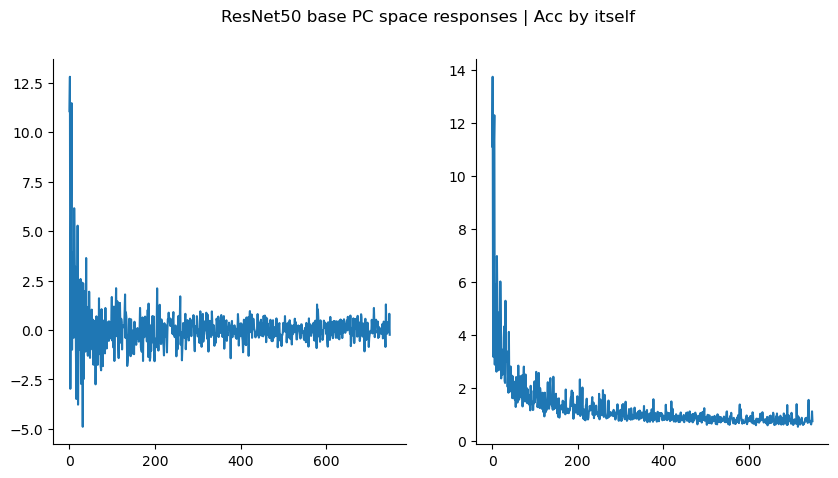

In [54]:
model_name = config["model_name"]
acc_img_PCA_resp_idx_per_model = df_accentuated.query("model_name == @model_name").index
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc_img_PCA_resp[acc_img_PCA_resp_idx_per_model, :].mean(dim=0))
plt.subplot(1, 2, 2)
plt.plot(acc_img_PCA_resp[acc_img_PCA_resp_idx_per_model, :].abs().mean(dim=0))
plt.suptitle("ResNet50 base PC space responses | Acc by itself")
plt.show()

In [59]:
df_accentuated.model_name.unique()

array(['siglip2_vitb16', 'resnet50_clip', 'resnet50_robust',
       'dinov2_vitb14_reg', 'AlexNet_training_seed_01', 'resnet50',
       'regnety_640', 'resnet50_dino', 'clipag_vitb32', 'radio_v2.5-b'],
      dtype=object)

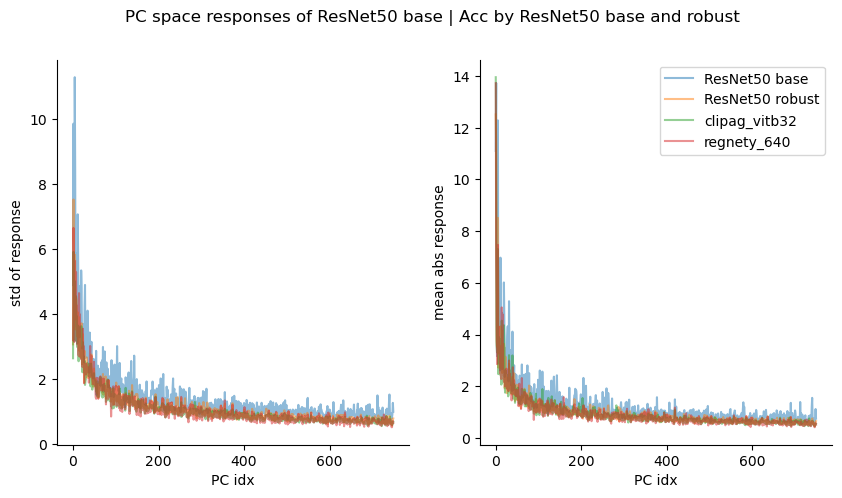

In [68]:
model_name = config["model_name"]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
acc_img_PCA_resp_idx_per_model = df_accentuated.query("model_name == @model_name").index
plt.plot(acc_img_PCA_resp[acc_img_PCA_resp_idx_per_model, :].std(dim=0), label="ResNet50 base", alpha=0.5)
acc_img_PCA_resp_idx_per_model = df_accentuated.query("model_name == 'resnet50_robust'").index
plt.plot(acc_img_PCA_resp[acc_img_PCA_resp_idx_per_model, :].std(dim=0), label="ResNet50 robust", alpha=0.5)
acc_img_PCA_resp_idx_per_model = df_accentuated.query("model_name == 'clipag_vitb32'").index
plt.plot(acc_img_PCA_resp[acc_img_PCA_resp_idx_per_model, :].std(dim=0), label="clipag_vitb32", alpha=0.5)
acc_img_PCA_resp_idx_per_model = df_accentuated.query("model_name == 'regnety_640'").index
plt.plot(acc_img_PCA_resp[acc_img_PCA_resp_idx_per_model, :].std(dim=0), label="regnety_640", alpha=0.5)
plt.xlabel("PC idx")
plt.ylabel("std of response")
plt.subplot(1, 2, 2)
acc_img_PCA_resp_idx_per_model = df_accentuated.query("model_name == @model_name").index
plt.plot(acc_img_PCA_resp[acc_img_PCA_resp_idx_per_model, :].abs().mean(dim=0), label="ResNet50 base", alpha=0.5)
acc_img_PCA_resp_idx_per_model = df_accentuated.query("model_name == 'resnet50_robust'").index
plt.plot(acc_img_PCA_resp[acc_img_PCA_resp_idx_per_model, :].abs().mean(dim=0), label="ResNet50 robust", alpha=0.5)
acc_img_PCA_resp_idx_per_model = df_accentuated.query("model_name == 'clipag_vitb32'").index
plt.plot(acc_img_PCA_resp[acc_img_PCA_resp_idx_per_model, :].abs().mean(dim=0), label="clipag_vitb32", alpha=0.5)
acc_img_PCA_resp_idx_per_model = df_accentuated.query("model_name == 'regnety_640'").index
plt.plot(acc_img_PCA_resp[acc_img_PCA_resp_idx_per_model, :].abs().mean(dim=0), label="regnety_640", alpha=0.5)
plt.xlabel("PC idx")
plt.ylabel("mean abs response")
plt.suptitle("PC space responses of ResNet50 base | Acc by ResNet50 base and robust")
plt.legend()
plt.show()

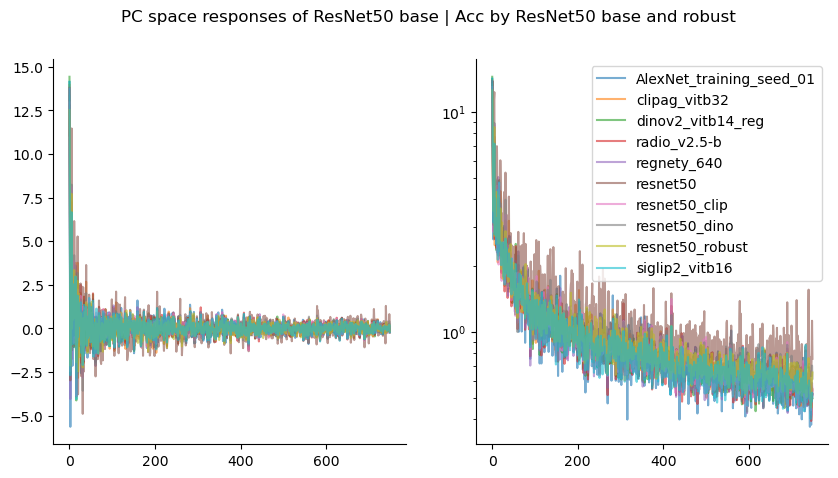

In [65]:
model_name = config["model_name"]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for model in sorted(df_accentuated.model_name.unique()):
    acc_img_PCA_resp_idx_per_model = df_accentuated.query("model_name == @model").index
    plt.plot(acc_img_PCA_resp[acc_img_PCA_resp_idx_per_model, :].mean(dim=0), label=model, alpha=0.6)
plt.subplot(1, 2, 2)
for model in sorted(df_accentuated.model_name.unique()):
    acc_img_PCA_resp_idx_per_model = df_accentuated.query("model_name == @model").index
    plt.plot(acc_img_PCA_resp[acc_img_PCA_resp_idx_per_model, :].abs().mean(dim=0), label=model, alpha=0.6)
plt.yscale("log")
plt.suptitle("PC space responses of ResNet50 base | Acc by ResNet50 base and robust")
plt.legend()
plt.show()

In [ ]:
model_name = config["model_name"]
acc_img_PCA_resp_idx_per_model = df_accentuated.query("model_name == @model_name").index

In [75]:
model_name

'resnet50'

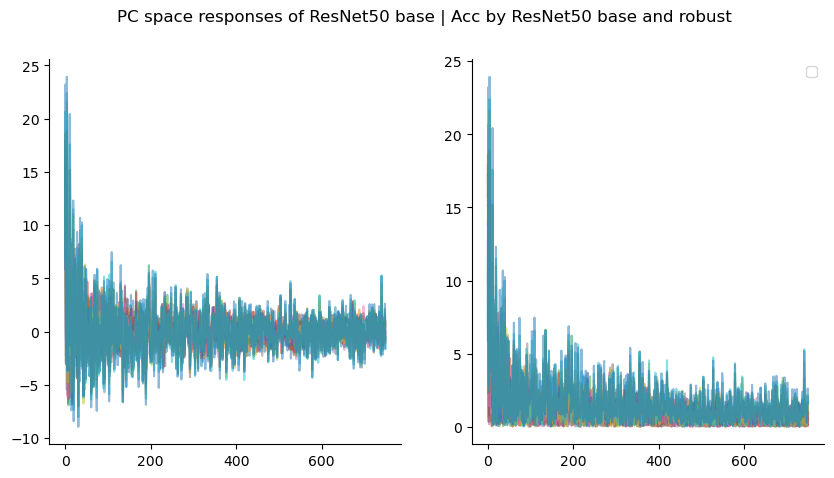

In [79]:
model_name = "resnet50" #config["model_name"]
acc_img_PCA_resp_idx_per_model_perseed = df_accentuated.query("model_name == @model_name and unit_id == 0 and img_id == 1").sort_values("score").index

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc_img_PCA_resp[acc_img_PCA_resp_idx_per_model_perseed, :].T, alpha=0.5)
plt.subplot(1, 2, 2)
plt.plot(acc_img_PCA_resp[acc_img_PCA_resp_idx_per_model_perseed, :].T.abs(), alpha=0.5)
# plt.yscale("log")
plt.suptitle("PC space responses of ResNet50 base | Acc by ResNet50 base and robust")
plt.legend()
plt.show()

In [ ]:
model_name = config["model_name"]
acc_img_PCA_resp_idx_per_model = df_accentuated.query("model_name == @model_name").index

In [ ]:
acc_img_PCA_resp_idx_per_model

Index([2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759,
       ...
       3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299],
      dtype='int64', length=550)

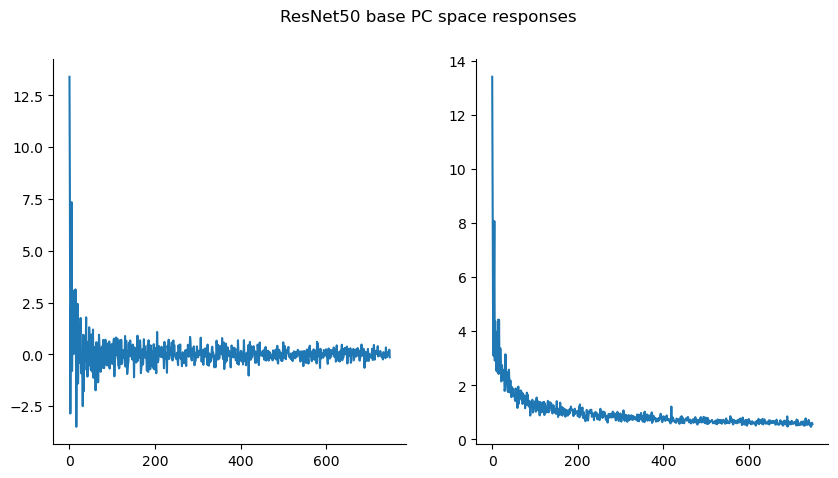

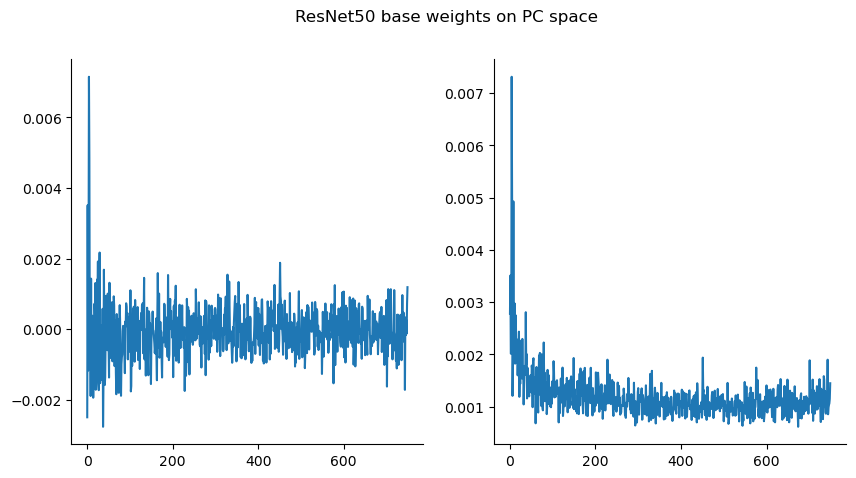

In [46]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc_img_PCA_resp.mean(dim=0))
plt.subplot(1, 2, 2)
plt.plot(acc_img_PCA_resp.abs().mean(dim=0))
plt.suptitle("ResNet50 base PC space responses")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(readout.weight.mean(dim=0).detach().cpu())
plt.subplot(1, 2, 2)
plt.plot(readout.weight.abs().mean(dim=0).detach().cpu())
plt.suptitle("ResNet50 base weights on PC space")
plt.show()

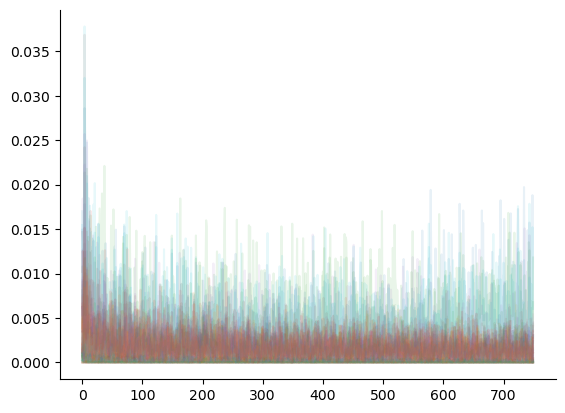

In [39]:
plt.plot(readout.weight.abs().detach().cpu().T, alpha=0.1);

### ResNet50 base

In [ ]:
config_file = config_pre_chan[8]

predict_reduced_feature, \
    model, transforms_pipeline, fetcher, Xtransform, readout \
        = get_PCA_basis_predictor_from_config(config_file, device="cuda")

accentuated_dataset = ImagePathDataset(df_accentuated["filepath"], transform=transforms_pipeline)
accentuated_dataloader = DataLoader(accentuated_dataset, batch_size=100, shuffle=False, num_workers=10)

acc_img_PCA_resp = get_prediction_responses(predict_reduced_feature, transforms_pipeline, 
                                        df_accentuated["filepath"])

Loading model and set up feature extraction: model resnet50, layer .layer4.Bottleneck0
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_Ch19_readout_.layer4.Bottleneck0_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_Ch19_Xtfmer_.layer4.Bottleneck0_pca750_RidgeCV_JITscript.pt


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/serialization.py:1006: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file t

torch.Size([1, 750])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform
The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/55 [00:00<?, ?it/s]